In [1]:
import numpy as np
import xarray as xr
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature

from MapXtremePCIC import MapXtremePCIC

In [2]:
PATH = './data/pr_24hr_50yrs/'

MapXtreme = MapXtremePCIC(50, 'eof', PATH)
data_cube = MapXtreme.load_data

In [3]:
data_cube['pr'][:, :, 2]

<xarray.DataArray 'pr' (x: 124, y: 149)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan, 2.552643, ...,      nan,      nan,      nan]])
Coordinates:
    lon      (x, y) float64 233.5 233.8 234.2 234.6 ... 331.5 332.0 332.5 333.0
    lat      (x, y) float64 14.04 14.2 14.36 14.51 ... 60.17 59.87 59.56 59.26
Dimensions without coordinates: x, y

In [4]:
#X_prime = MapXtreme.ensemble_mean(data_cube)

In [5]:
# RAM heavy
#X = MapXtreme.weight_matrix(data_cube)

In [6]:
data_cube_sample = MapXtreme.sample(data_cube, 0.3)

/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/matplotlib/colors.py:957: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


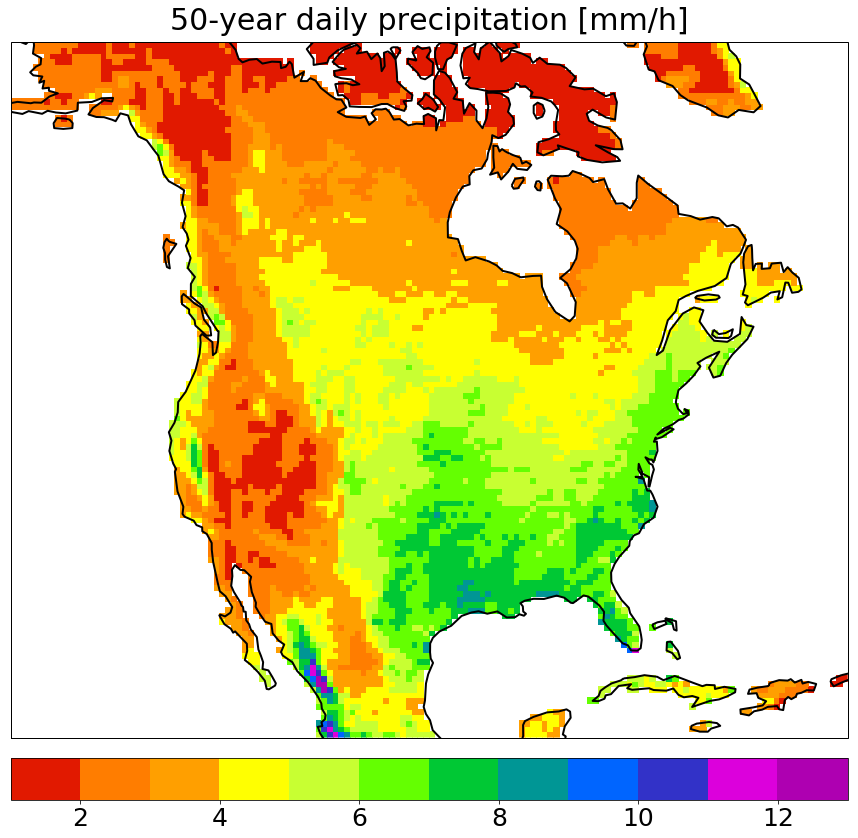

In [7]:
MapXtreme.plot_reference(data_cube)

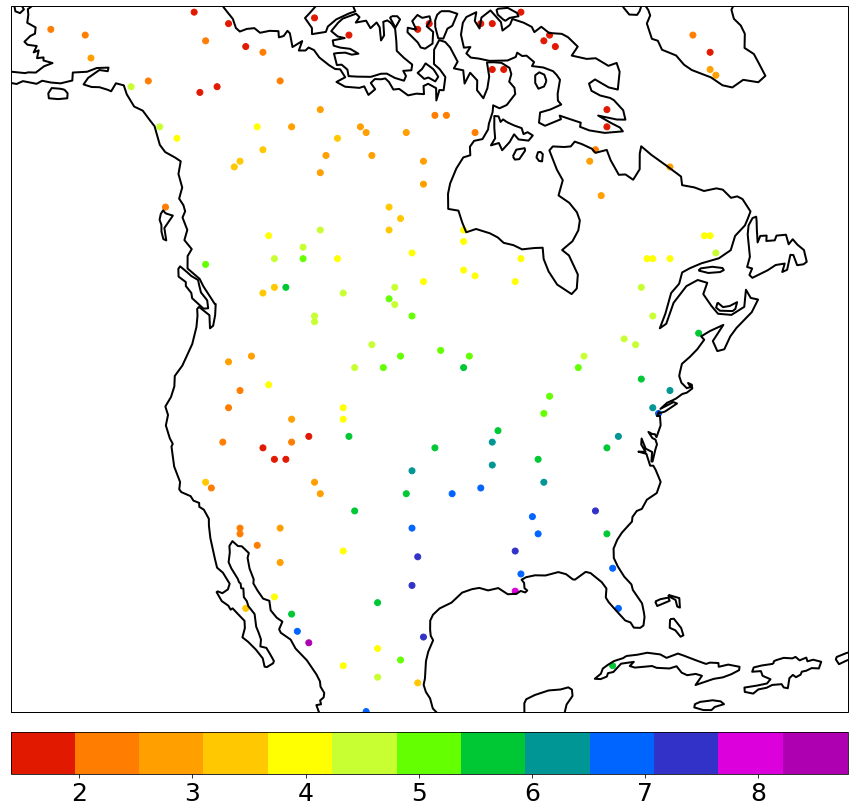

In [8]:
MapXtreme.plot_scatter(data_cube, frac=0.02)

<xarray.Dataset>
Dimensions:  (rlat: 124, rlon: 149, x: 124, y: 149)
Coordinates:
    lon      (x, y) float64 233.5 233.8 234.2 234.6 ... 331.5 332.0 332.5 333.0
    lat      (x, y) float64 14.04 14.2 14.36 14.51 ... 60.17 59.87 59.56 59.26
  * rlon     (rlon) float64 -32.12 -31.68 -31.24 -30.8 ... 32.12 32.56 33.0
  * rlat     (rlat) float64 -26.84 -26.4 -25.96 -25.52 ... 26.4 26.84 27.28
Dimensions without coordinates: x, y
Data variables:
    pr       (x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Attributes:
    pr:       mm h-1
    lon:      degrees
    lat:      degrees
    rlon:     degrees
    rlat:     degrees


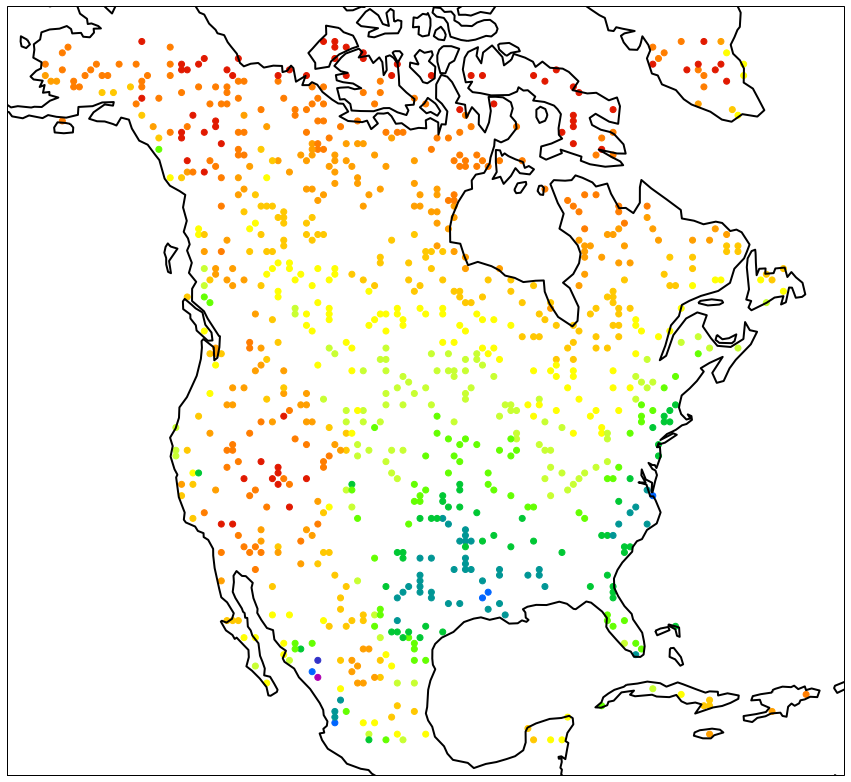

In [182]:
import pandas as pd

# approximate grid size
lat_grid_sz = ((data_cube['rlat'].max() - data_cube['rlat'].min())/data_cube['rlat'].shape[0])
lon_grid_sz = ((data_cube['rlon'].max() - data_cube['rlon'].min())/data_cube['rlon'].shape[0])

# construct a pandas dataframe
pr_n = data_cube['pr'].mean(axis=2)

# reshape the lat/lon grids
lat = np.reshape(data_cube['lat'].values, (data_cube['lat'].shape[0]*data_cube['lat'].shape[1]))
lon = np.reshape(data_cube['lon'].values, (data_cube['lon'].shape[0]*data_cube['lon'].shape[1]))

# reshape the pr grids
pr = np.reshape(pr_n.values,  (data_cube['lat'].shape[0]*data_cube['lat'].shape[1]))

# set up repeating values of rlat, rlon times
rlat = np.repeat(data_cube['rlat'].values, data_cube['rlon'].shape[0]) + lat_grid_sz.values
# set up repeating sequence of rlon, rlat times
rlon = np.tile(data_cube['rlon'].values, data_cube['rlat'].shape[0]) + lon_grid_sz.values

# create a dictionary from arrays
pd_dict = {'lat': lat, 'lon': lon, 'rlon': rlon, 'rlat': rlat, 'pr': pr}


cdict = {'#e11900':1, '#ff7d00':2, '#ff9f00':3, 
         '#ffc801':4, '#ffff01':5, '#c8ff32':6, 
         '#64ff01':7, '#00c834':8, '#009695':9, 
         '#0065ff':10, '#3232c8':11, '#dc00dc':12, '#ae00b1':12}

cmap = mpl.colors.ListedColormap(cdict)

# create dataframe from pd dict
df = pd.DataFrame(pd_dict)
# mask out ocean
df = df[df['pr'] != 0.0]
# take a random sample
df = df.sample(frac=0.1)

# reasemble the xarray Dataset
lat_r = np.reshape(lat, (data_cube['lat'].shape[0], data_cube['lat'].shape[1]))
lon_r = np.reshape(lon, (data_cube['lon'].shape[0], data_cube['lon'].shape[1]))

rlat_r = np.unique(rlat)
rlon_r = np.unique(rlon)

pr_r = np.reshape(pr, (data_cube['pr'].shape[0], data_cube['pr'].shape[1]))

ds = xr.Dataset({'pr': (['x', 'y'], pr_r)}, 
                coords = {'lon': (['x', 'y'], lon_r), 
                          'lat': (['x', 'y'], lat_r), 
                          'rlon': rlon_r, 
                          'rlat': rlat_r},
                attrs = {'pr': 'mm h-1',
                         'lon': 'degrees',
                         'lat': 'degrees',
                         'rlon': 'degrees',
                         'rlat': 'degrees'})

print(ds)

rp = ccrs.RotatedPole(pole_longitude=-97.45 + 180, pole_latitude=42.76)

plt.figure(figsize = (15, 15))
ax = plt.axes(projection=rp)
ax.coastlines('110m', linewidth=2.)

ax.scatter(df['rlon'], df['rlat'], c = df['pr'], cmap = cmap, transform = rp)

In [61]:
help(np.reshape)

Help on function reshape in module numpy.core.fromnumeric:

reshape(a, newshape, order='C')
    Gives a new shape to an array without changing its data.
    
    Parameters
    ----------
    a : array_like
        Array to be reshaped.
    newshape : int or tuple of ints
        The new shape should be compatible with the original shape. If
        an integer, then the result will be a 1-D array of that length.
        One shape dimension can be -1. In this case, the value is
        inferred from the length of the array and remaining dimensions.
    order : {'C', 'F', 'A'}, optional
        Read the elements of `a` using this index order, and place the
        elements into the reshaped array using this index order.  'C'
        means to read / write the elements using C-like index order,
        with the last axis index changing fastest, back to the first
        axis index changing slowest. 'F' means to read / write the
        elements using Fortran-like index order, with the firs